In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def ar_subtract_point(some_ar, index_to_omit, some_point):
    ar = some_ar - some_point
    ar = -ar
    return np.delete(ar, index_to_omit, axis = 0)

def one_lagrangian_product(x_vals, index_to_omit, some_point):
    return np.prod(ar_subtract_point(x_vals, index_to_omit, some_point))

def get_all_lagrangian_part_products(x_vals, points):
    return np.array([one_lagrangian_product(x_vals, i, points[i])
                     for i in range(len(points))]).astype(float)

def lagrange_interpolation(x_vals, y_vals, x_point):
    numerators = get_all_lagrangian_part_products(x_vals, np.ones(x_vals.shape) * x_point)
    print numerators 
    denomenators = get_all_lagrangian_part_products(x_vals, x_vals)
    print denomenators
    print numerators / denomenators, np.abs(numerators / denomenators) * (np.array([4., 4., 6., 9.]) * 0.0001)
    return np.sum( (numerators / denomenators) * y_vals )

'''def lagrange_derivative(x_vals, y_vals, x_point):
    numerators = get_all_lagrangian_part_products(x_vals, np.ones(x_vals.shape) * x_point)
    denomenators = get_all_lagrangian_part_products(x_vals, x_vals)
    def get_one_derivative_multiplicator(some_index):
        return np.sum(np.reciprocal(ar_subtract_point(x_vals, some_index, x_point)))
    derivative_multiplicators = np.array([get_one_derivative_multiplicator(i) 
                                          for i in range(len(x_vals))])
    print derivative_multiplicators
    return np.sum( ((numerators / denomenators) * derivative_multiplicators) * y_vals )
'''

def lagrange_derivative_at_some_x(x_vals, y_vals, ind):
    first_part = y_vals[ind] * np.sum(np.reciprocal(ar_subtract_point(x_vals, ind, x_vals[ind])))
    denomenators = get_all_lagrangian_part_products(x_vals, x_vals)
    denomenators = np.delete(denomenators, ind, axis = 0)
    tmp_x_vals = np.delete(x_vals, ind, axis = 0)
    numerators = get_all_lagrangian_part_products(tmp_x_vals, np.ones(tmp_x_vals.shape) * x_vals[ind])
    second_part = np.sum( (numerators / denomenators) * np.delete(y_vals, ind, axis = 0))
    return first_part + second_part

In [3]:
def newton_interpolation(x_vals, y_vals, x_point):
    def get_finite_differences():
        ar_len = len(x_vals)
        result = np.zeros((ar_len, ar_len))
        for i in range(ar_len):
            result[i][i] = y_vals[i]
        for cur_len in np.arange(2, ar_len + 1):
            for i in np.arange(0, ar_len - cur_len + 1):
                j = i + cur_len - 1
                result[i][j] = (result[i+1][j] - result[i][j-1]) / (x_vals[j] - x_vals[i])
        return result.astype(float)
    b_coefficients = get_finite_differences()[0]
    dif_ar = ar_subtract_point(x_vals, len(x_vals) - 1, x_point)
    dif_ar = np.array([1] + dif_ar.tolist())
    cumprods = np.cumprod(dif_ar)
    return np.sum(b_coefficients * cumprods)


In [4]:
def functor_from_interpolator(some_interpolator, x_vals, y_vals):
    def calcer(x_point):
        return some_interpolator(x_vals, y_vals, x_point)
    return calcer

In [5]:
def get_splyne_coefficients(x_i_1, x_i, P_N_1, P_N, P_N_1_shtrih, P_N_shtrih):
    delta = x_i_1 - x_i
    delta_f = P_N_1 - P_N
    a_3 = ((P_N_1_shtrih + P_N_shtrih) * delta - 2 * delta_f) / (delta ** 3)
    a_2 = (-P_N_1_shtrih * (2 * x_i + x_i_1) * delta - P_N_shtrih * (x_i + 2 * x_i_1) * delta +
           3*delta_f *(x_i + x_i_1)) / (delta ** 3)
    a_1 = (P_N_1_shtrih * x_i * (x_i + 2 * x_i_1) * delta +
           P_N_shtrih * x_i_1 * (2 * x_i + x_i_1) * delta -
           6*delta_f*x_i*x_i_1) / (delta ** 3)
    a_0 = (-P_N_1_shtrih * x_i * x_i_1 * delta * x_i -
           P_N_shtrih * x_i * x_i_1 * delta * x_i_1 +
          P_N_1 * x_i * x_i * (3 * x_i_1 - x_i) +
          P_N * x_i_1 * x_i_1 * (x_i_1 - 3 * x_i) )/ (delta ** 3)
    return np.array([a_3, a_2, a_1, a_0])

class splyne_calcer:
    def __init__(self, x_vals, y_vals):
        self.x_vals = x_vals
        self.P_N_vals = y_vals
        self.P_N_shtrih_vals = np.array([lagrange_derivative_at_some_x(x_vals, y_vals, some_ind)
                                         for some_ind in range(len(x_vals))])
        
        
    def __call__(self, x_point):
        return self.calc_splyne_polynomial(x_point, self.findleftindex(x_point))
        
    def findleftindex(self, x_point):
        segm_index = np.searchsorted(self.x_vals, x_point)
        if segm_index == 0:
            return 0
        if segm_index == len(self.x_vals):
            return len(self.x_vals) - 2
        return segm_index - 1
    
    def calc_splyne_polynomial(self, x_point, fst_segment_index):
        coefs = get_splyne_coefficients(self.x_vals[fst_segment_index + 1], self.x_vals[fst_segment_index],
                                    self.P_N_vals[fst_segment_index + 1], self.P_N_vals[fst_segment_index],
                                    self.P_N_shtrih_vals[fst_segment_index + 1], self.P_N_shtrih_vals[fst_segment_index])
        x_degs = [x_point ** 3, x_point * x_point, x_point, 1]
        return np.sum(coefs * x_degs)

In [6]:
def make_report(some_arguments):
    some_arguments =  sorted(some_arguments)
    x_vals = np.array(map(lambda x: x[0], some_arguments))
    y_vals = np.array(map(lambda x: x[1], some_arguments))
    functors = [functor_from_interpolator(some_func, x_vals, y_vals) for
                some_func in[lagrange_interpolation, newton_interpolation] ] + [splyne_calcer(x_vals, y_vals)]
    #points_to_calc = (x_vals[1:] + x_vals[:-1]) * 0.5
    points_to_calc = np.array([2.25])
    col_names = ['points', 'lagrange', 'newton', 'splynes']
    dataframe_vals = [[x_point] + [cur_functor(x_point) for cur_functor in functors] for x_point in points_to_calc]
    dataframe_vals = np.array(dataframe_vals)
    df = pd.DataFrame(data = dataframe_vals, columns=col_names)
    #import scipy.interpolate as ogogo
    #print [ogogo.lagrange(x_vals, y_vals)(cur_x) for cur_x in points_to_calc]
    print df
    def make_graph_for_col(cur_col):
        def get_borders(ar):
            eps = .1
            min_mult = 1-eps
            max_mult = 1+eps
            ans = []
            for elem, mults in zip([np.min(ar), np.max(ar)], [[min_mult, max_mult], [max_mult, min_mult]]):
                if elem == 0:
                    ans.append(mults[0] - 1)
                else:
                    if elem > 0:
                        ans.append(mults[0] * elem)
                    else:
                        ans.append(mults[1] * elem)
            return tuple(ans)
        
        cur_x_vals = df['points'].values.flatten()
        cur_y_vals = df[cur_col].values.flatten()
        plt.plot(cur_x_vals, cur_y_vals)
        plt.xlim(get_borders(cur_x_vals))
        plt.ylim(get_borders(cur_y_vals))
        plt.xlabel('x values')
        plt.ylabel('y values')
        plt.title(cur_col)
        plt.figure(figsize = (15, 12))
        plt.show()
    for cur_col in col_names[1:]:
        make_graph_for_col(cur_col)
    print 'splyne_vals at given points are ', [splyne_calcer(x_vals, y_vals)(cur_x) for cur_x in x_vals]

[  6.4343658    7.35033     10.42977     18.53873125]
[-1.06996545  0.5841234  -0.9171666   3.1953267 ]
[ -6.01362016  12.58352259 -11.37172897   5.80182654] [ 0.00240545  0.00503341  0.00682304  0.00522164]
   points  lagrange    newton   splynes
0    2.25  0.747747  0.747747  0.747747


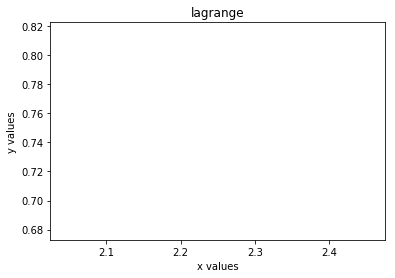

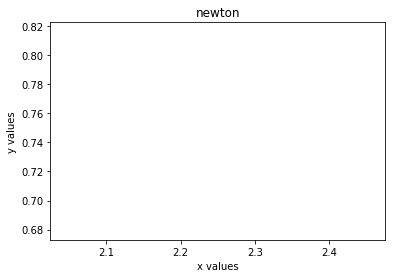

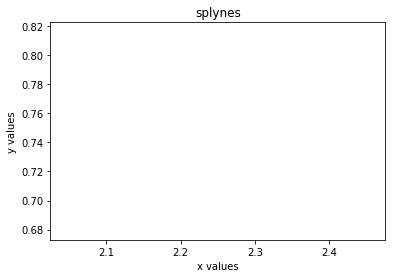

splyne_vals at given points are  [8.3266726846886741e-16, 0.10000000000000062, 0.30000000000000004, 0.50000000000000022]


In [7]:
#arguments = [(0.5236, 0), (0.87267, 0.00017), (1.22173, 0.00199),
 #            (1.5708, 0.01282), (1.91986, 0.05744)]
arguments = [(-1., 0.), (-0.595, 0.1), (0.245, 0.3), (1.122, 0.5)]
make_report(arguments)

In [8]:
aaaa = np.array(map(lambda x: x[0], arguments))
np.prod(aaaa)/120.0

0.0013629962500000001

In [9]:
print np.prod(2.25-np.arange(0, 4))/6.

-0.087890625


[-0.234375 -0.421875 -2.109375  0.703125]
[-6.  2. -2.  6.]
[ 0.0390625 -0.2109375  1.0546875  0.1171875] [  1.56250000e-05   8.43750000e-05   6.32812500e-04   1.05468750e-04]
   points  lagrange   newton  splynes
0    2.25   0.00067  0.00067  0.00067


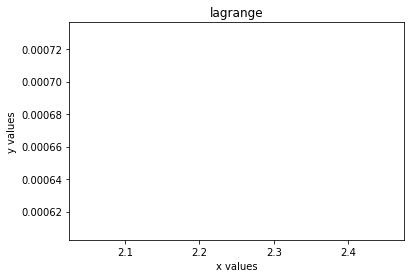

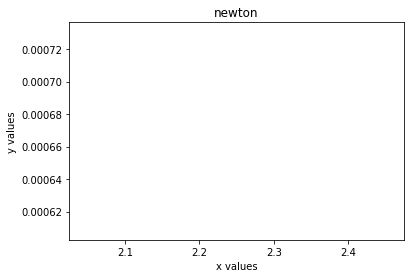

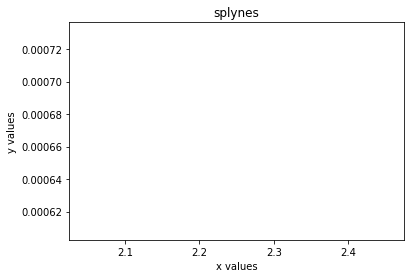

splyne_vals at given points are  [0.00040000000000000002, 0.00040000000000000002, 0.00060000000000000049, 0.00089999999999999737]


In [10]:
arguments = [(0. , 0.0004), (1., 0.0004), (2., 0.0006), (3., 0.0009)]
make_report(arguments)